In [1]:
import re

import tellurium as te
import libsbml as ls
import pandas as pd
import seaborn as sns

fn_ant = '../model/euromix.ant'

In [2]:
q_cols = {'1':'QVen', '2':'QArt', '3':'QFat', '4':'QPoor', '5':'QRich', '6':'QLiver',
                          '7':'QSkin_u', '8':'QSkin_e', '9':'QSkin_sc_u', '10':'QSkin_sc_e',
                          '11':'QGut', '12':'QExcret', '13':'QMetab'}

def get_r_results(fn):
    r_out = pd.read_csv(f'../results/{fn}').drop(columns=['Unnamed: 0'])
    r_out.rename(columns=q_cols, inplace=True)    
    r_out['QTotal'] = r_out.drop(columns=['time', 'CTotal']).sum(axis=1)    
    long_r = pd.melt(r_out[['time']+list(q_cols.values())+['QTotal']], id_vars=['time'], 
                     value_vars=list(q_cols.values())+['QTotal'], 
                     var_name='quantity', value_name='value')
    long_r['src'] = 'R'
    return long_r

In [11]:
def get_vol_map(fn):
    """Get volume of the matching compartment for every species"""
    # load ant model and save as sbml    
    r = te.loada(fn)
    r.exportToSBML(fn.replace('.ant','.sbml'))
    # Load SBML
    document = ls.readSBML(fn.replace('.ant','.sbml'))
    model = document.getModel()
    print(model)
    # iterate over species and get compartment sizes
    return {s.id : model.getCompartment(s.compartment).size for s in model.getListOfSpecies()}


def get_amounts_as_df(results):
    """Process results from roadrunner to get ammounts.

    Roadrunner returns the concentration of each species, also for substanceOnlySpecies. 
    This function 
    """
    names = [re.sub(r'\[(.*?)\]', r'\1', name) for name in results.colnames]
    df = pd.DataFrame(results, columns=names).fillna(0)
    for name, vol in get_vol_map(fn_ant).items():
        if vol == 0:
            continue
        df[name] = df[name]*vol
    df['QTotal'] = df.drop(columns='time').sum(axis=1)
    return df

In [12]:
def compare(results, fn_r):
    df = get_amounts_as_df(results)
    long_df = pd.melt(df, id_vars=['time'], value_vars=df.columns[1:], var_name='quantity', value_name='value')
    long_df['src'] = 'sbml'
    long_r = get_r_results(fn_r)
    all_df = pd.concat((long_df, long_r))    
    g = sns.FacetGrid(all_df, col='quantity', hue='src', col_wrap=5, sharey=False,
                     col_order=list(q_cols.values())+['QTotal'])
    g.map(sns.lineplot, 'time', 'value')
    g.add_legend()


# Mass action kinetics

<Model euromix>


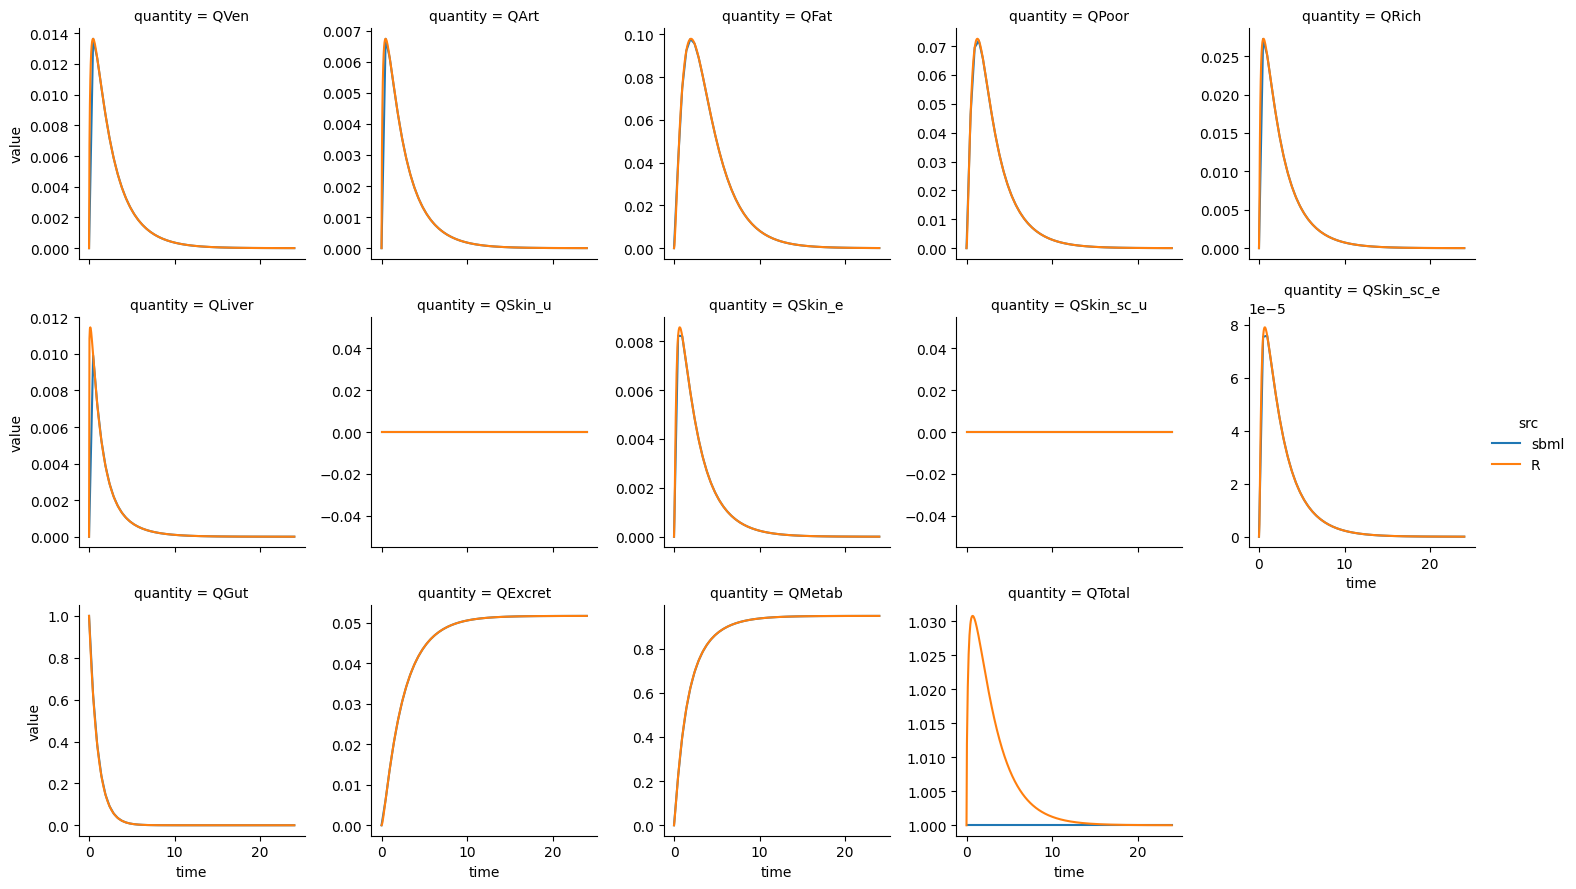

In [13]:
r = te.loada(fn_ant)
r.QGut = 1
compare(r.simulate(0, 24),fn_r='euromix_r_results_MA.csv')

Because there is only a single dose, `QGut = 1` at `t = 0`, and nothing is taken out of the system, the total amount in the system should be constant. `QTotal` is the sum of all amounts and indeed remains constant for the sbml simulation. For R we see a slight deviation when the system is not in equilibium, which is most likely the result of the interpolation of the time steps in the R output.

# Michaelis menten kinetics

<Model euromix>


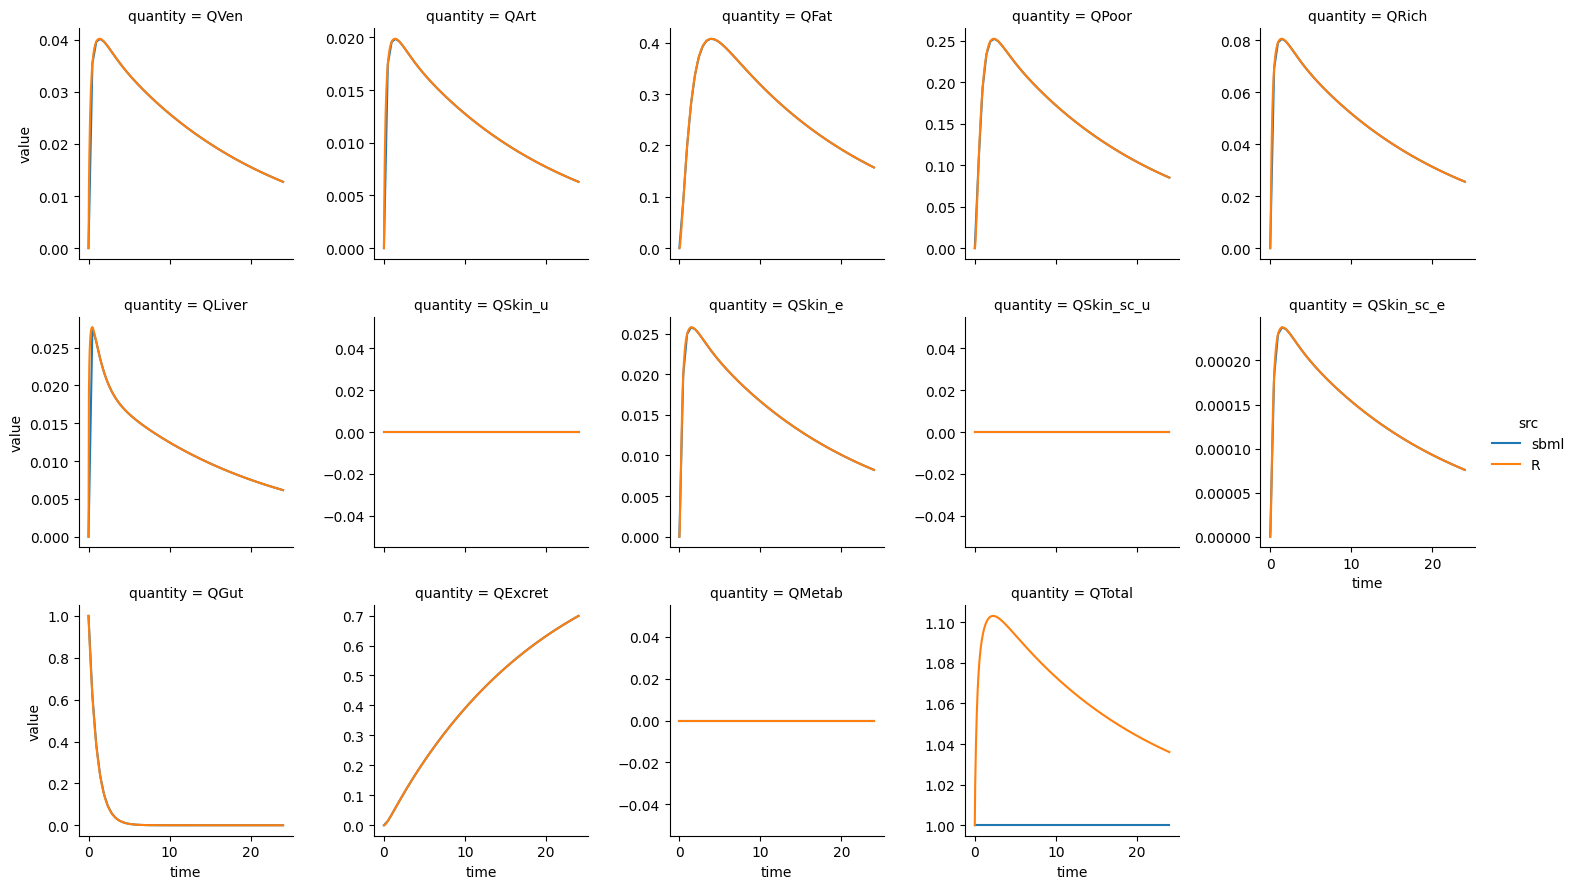

In [14]:
r = te.loada(fn_ant)
r.QGut = 1
r.Michaelis = 1
r.Km = 1
compare(r.simulate(0, 24),fn_r='euromix_r_results_MM.csv')

Because there is only a single dose, `QGut = 1` at `t = 0`, and nothing is taken out of the system, the total amount in the system should be constant. `QTotal` is the sum of all amounts and indeed remains constant for the sbml simulation. For R we see a slight deviation when the system is not in equilibium, which is most likely the result of the interpolation of the time steps in the R output.